# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [15]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [ ]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)



auc score without fs: 0.7119236883942767
auc score wiht fs: 0.7356915739268681


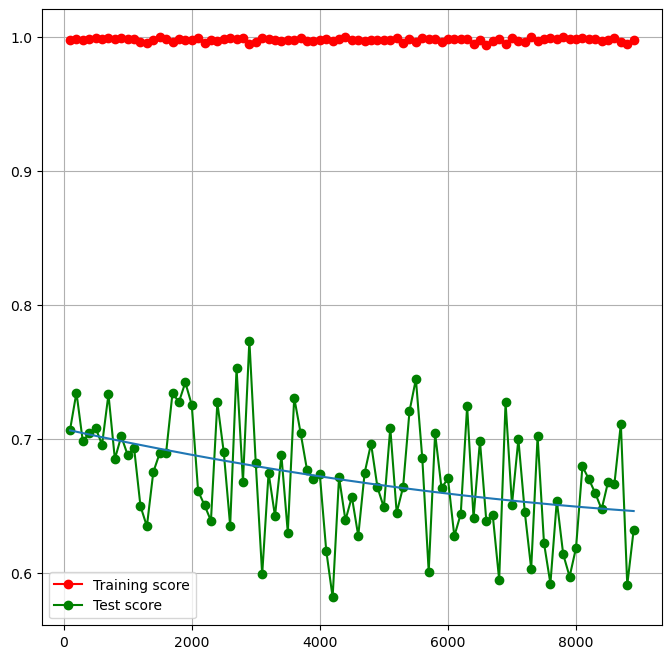

In [34]:
train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)
for k in k_list:
    rf = Pipeline([('feature_selection', SelectKBest(f_classif, k=k)), ('rfc', RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42))])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.legend()


In [ ]:
np.random.seed(42)

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt'))
                 ])

param_dist = {
    'feature_selection__k': [*np.arange(100, 1000, 50), 9000], #[300, 400, 500, 9000],
    'classifier__n_estimators': np.arange(10, 100, 5), #[30, 40, 50],
    'classifier__min_samples_split': np.arange(2, 20, 2), #[5, 10, 15],
    'classifier__max_depth': [*np.arange(5, 25, 5), None], #[5, 10, 15, None],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

n_iterations = 20

random_search = model_selection.RandomizedSearchCV(
                                            pipe, 
                                            param_distributions=param_dist, 
                                            cv=model_selection.StratifiedKFold(n_splits=4), 
                                            n_iter=n_iterations,
                                            scoring='roc_auc', 
                                            n_jobs=-1
                                            )
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'feature_selection__k': 650, 'classifier__n_estimators': 75, 'classifier__min_samples_split': 2, 'classifier__max_depth': 15, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.8378271563710787
